IBM Machine Learning Professional Certificate<br>
__Specialized Models: Time Series and Survival Analysis__

# BTCUSD TimeSeries (LSTM vs RNN)
***

__Author__: Chawit Kaewnuratchadasorn<br>
__Date__: 27th Feb 2022<br>

This notebook was created for Specialized Models: Time Series and Survival Analysis of IBM Machine Learning certificate. The time series analysis is conducted on Bitcoin (BTC) price in US dollars. The time series data were obtained via alphavantage API, following the second method on [Medium blog](https://medium.com/codex/10-best-resources-to-fetch-cryptocurrency-data-in-python-8400cf0d0136). This project aims to practice time series analysis as studied from the lectures. 

The contents include:
> 0. Libraries
> 1. Overview of BTCUSD - Selection of Volume and Close price
>> Upsampling of Volume<br>
>> Autocorrelation Plots
> 2. Stationary Transformation of Close Price with ADF Test
>> Trend and Seasonality Removal <br>
>> Differencing and Log Transformation <br>
> 3. Smoothing
>> Moving Average Smoothing <br>
>> Exponential Smoothing <br>
> 4. Model (ARMA)
>> AR on Volume<br>
>> MA on Close Price
> 5. Prediction by RNN and LSTM
> 6. Summary

First, the scraping function below was obtained from [Medium blog](https://medium.com/codex/10-best-resources-to-fetch-cryptocurrency-data-in-python-8400cf0d0136). I decided to obtain data from 2020 during pandamic because the price at the very start is extremely different from today's price. Therefore, it might be difficult and not accurate for machine learning model.

In [1]:
# scraping function by alphavantage API
def get_crypto_price(symbol, exchange, start_date = None):
    api_key = 'YOUR API KEY'
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={exchange}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T
    df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

## 0. Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import requests

import seaborn as sns
from colorsetup import colors, palette
sns.set_palette(palette)
from matplotlib import pyplot as plt
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
import statsmodels.api as sm

plotsize = (15, 4)

## 1. Overview of BTCUSD

In [3]:
# call the scraping function
btcusd = get_crypto_price(symbol = 'BTC', exchange = 'USD', start_date = '2020-01-01') # from 2020, January 1
btcusd.head()

,open,high,low,close,volume
2020-01-01,7195.24,7255.0,7175.15,7200.85,16792.388165
2020-01-02,7200.77,7212.5,6924.74,6965.71,31951.483932
2020-01-03,6965.49,7405.0,6871.04,7344.96,68428.500451
2020-01-04,7345.00,7404.0,7272.21,7354.11,29987.974977
2020-01-05,7354.19,7495.0,7318.00,7358.75,38331.085604


In [4]:
print("Number of days", btcusd.shape[0])
print("Number of columns", btcusd.shape[1], ", including",  [i for i in btcusd.columns])

Number of days 799
Number of columns 5 , including ['open', 'high', 'low', 'close', 'volume']


In this notebook, we will analyse only __volume__ and __close price__ because high, low, and open prices are relatively close to close price. Thus, choosing only one is more appropriate. Volume, however, is quite different from price. Therefore, it is important to also analyse volume.

In [5]:
data = btcusd[["volume","close"]]
data.head()

,volume,close
2020-01-01,16792.388165,7200.85
2020-01-02,31951.483932,6965.71
2020-01-03,68428.500451,7344.96
2020-01-04,29987.974977,7354.11
2020-01-05,38331.085604,7358.75


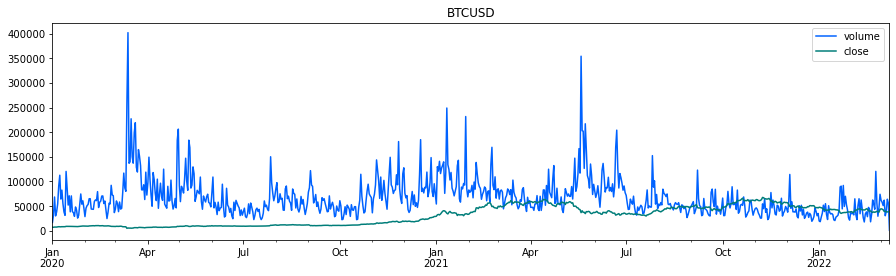

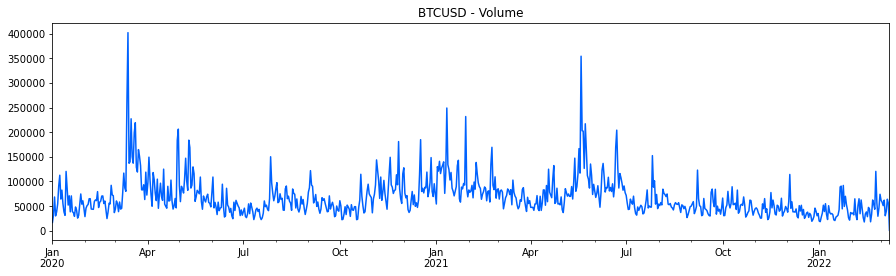

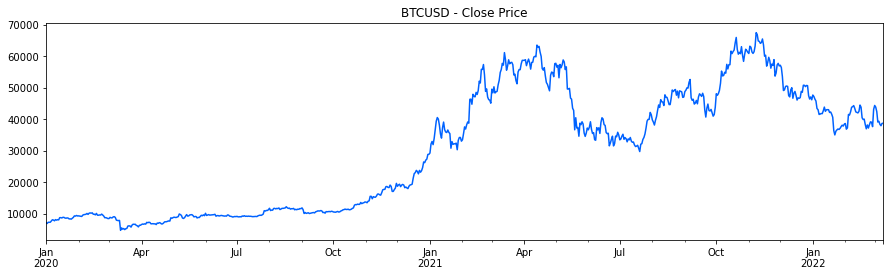

In [8]:
data.plot(figsize = plotsize, title = "BTCUSD")
plt.show()
data["volume"].plot(figsize = plotsize, title = "BTCUSD - Volume")
plt.show()
data["close"].plot(figsize = plotsize, title = "BTCUSD - Close Price")
plt.show()

### 1.1 Upsampling

Here, we plot the upsampling of volume because volume can be added up, unlike price. Price is dependent on previous data while volume is independent.

In [7]:
volume_weekly = data["volume"].resample('W').sum()
print('Weekly Volume')
print(volume_weekly.head(), '\n')

volume_monthly = data["volume"].resample('M').sum()
print('Monthly Volume')
print(volume_monthly.head(), '\n')

volume_quarterly = data["volume"].resample('Q').sum()
print('Quarterly Volume')
print(volume_quarterly.head(), '\n')

volume_annual = data["volume"].resample('Y').sum()
print('Annual Volumes')
print(volume_quarterly.head())

Weekly Volume
2020-01-05    185491.433129
2020-01-12    498017.846898
2020-01-19    468235.627496
2020-01-26    250977.001765
2020-02-02    362870.208388
Freq: W-SUN, Name: volume, dtype: float64 

Monthly Volume
2020-01-31    1.691323e+06
2020-02-29    1.609726e+06
2020-03-31    3.789769e+06
2020-04-30    2.528374e+06
2020-05-31    2.685340e+06
Freq: M, Name: volume, dtype: float64 

Quarterly Volume
2020-03-31    7.090818e+06
2020-06-30    6.718459e+06
2020-09-30    5.129409e+06
2020-12-31    6.794967e+06
2021-03-31    8.052689e+06
Freq: Q-DEC, Name: volume, dtype: float64 

Annual Volumes
2020-03-31    7.090818e+06
2020-06-30    6.718459e+06
2020-09-30    5.129409e+06
2020-12-31    6.794967e+06
2021-03-31    8.052689e+06
Freq: Q-DEC, Name: volume, dtype: float64


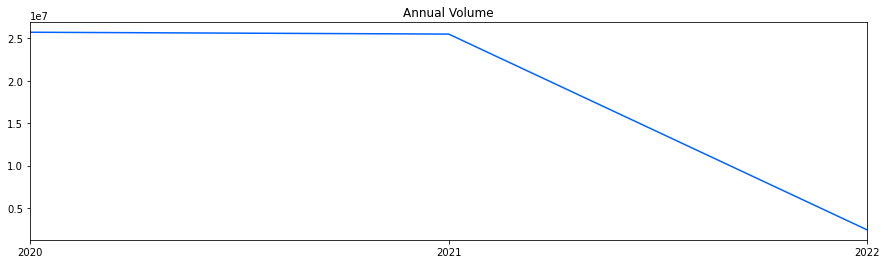

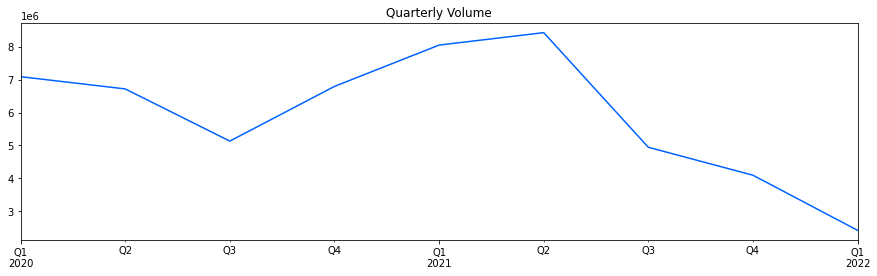

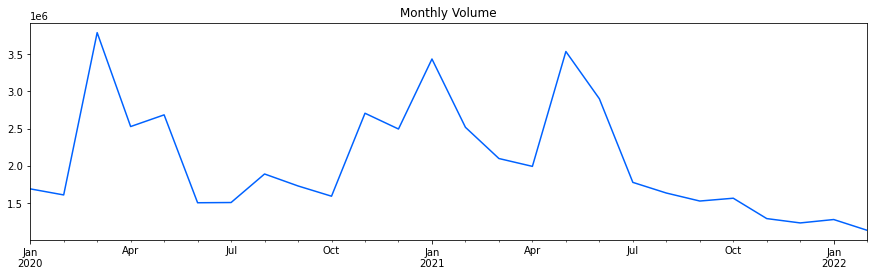

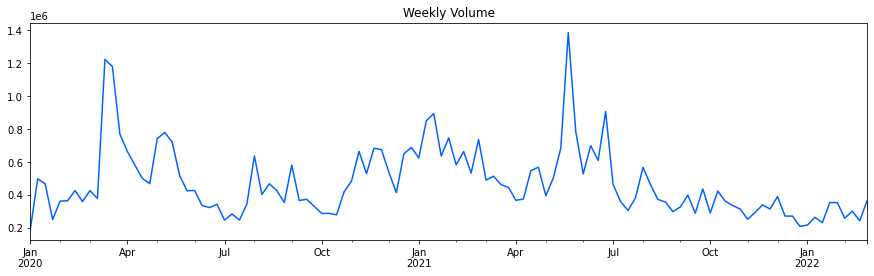

In [8]:
volume_annual.plot(figsize=plotsize, title='Annual Volume')
plt.show()
volume_quarterly.plot(figsize=plotsize, title='Quarterly Volume')
plt.show()
volume_monthly.plot(figsize=plotsize, title='Monthly Volume')
plt.show()
volume_weekly.plot(figsize=plotsize, title='Weekly Volume')
plt.show()

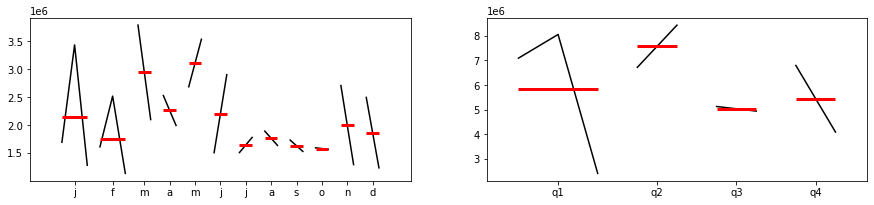

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,3))
m_plot = month_plot(volume_monthly, ax = ax1)
q_plot = quarter_plot(volume_quarterly, ax = ax2)

### Autocorrelation Plots

The autocorrelation and partial autocorrelation were plotted for volume and close price. The lag is set for 7, 30, 365 days.

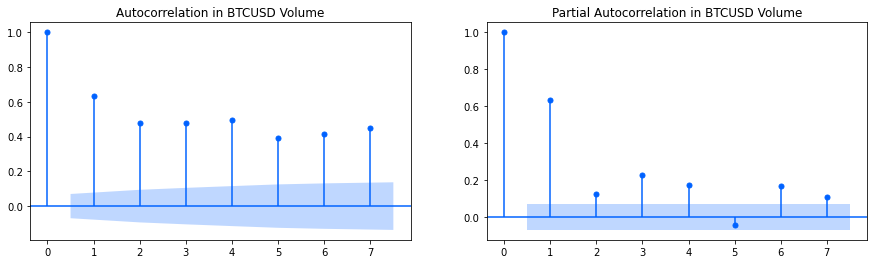

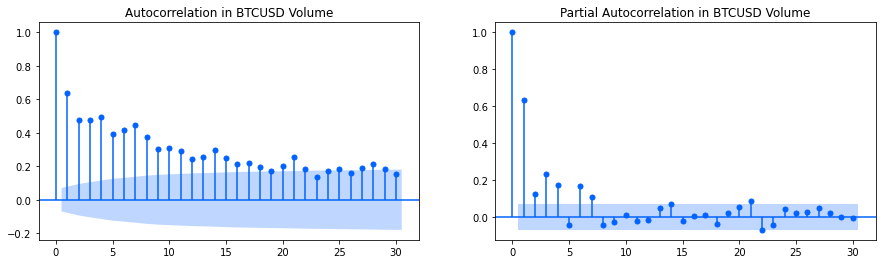

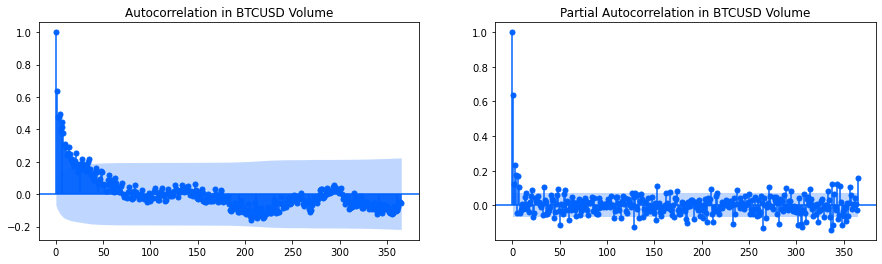

In [10]:
# Autocorrelation of Volume
for i in [7, 30, 365]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = plotsize)
    acf = plot_acf(data["volume"], ax = ax1, lags = i, title = 'Autocorrelation in BTCUSD Volume')
    pacf = plot_pacf(data["volume"], ax = ax2, lags = i, title = 'Partial Autocorrelation in BTCUSD Volume')
    plt.show()

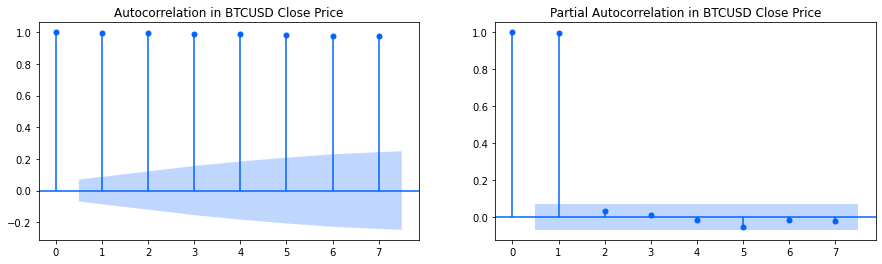

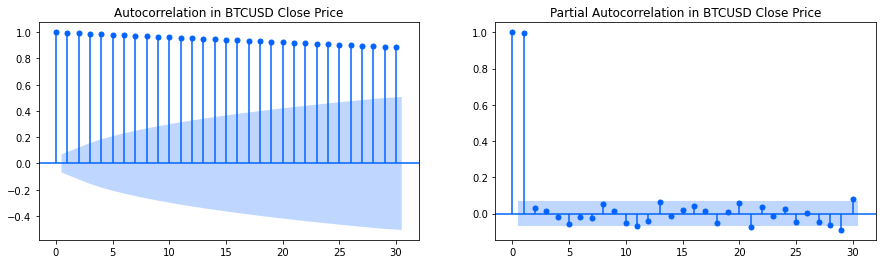

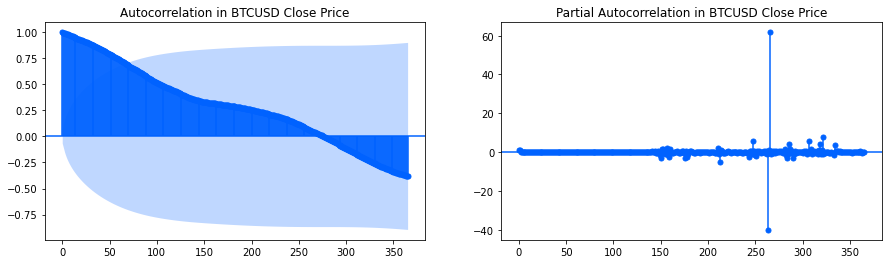

In [11]:
# Autocorrelation of Close Price
for i in [7, 30, 365]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = plotsize)
    acf = plot_acf(data["close"], ax = ax1, lags = i, title = 'Autocorrelation in BTCUSD Close Price')
    pacf = plot_pacf(data["close"], ax = ax2, lags = i, title = 'Partial Autocorrelation in BTCUSD Close Price')
    plt.show()

## 2. Stationary Transformations of Close Price with ADF Test

In this section, we firstly check the stationarity of volume and close price of BTCUSD by Augmented Dickey-Fuller test or ADF Test. From below code, we conclude that BTCUSD volume is stationary while close price is not stationary. Then, we will transform the close price by trend and seasonality removal, and difference and log transformation to obtain stationary series for later process.

In [12]:
adf_1, pvalue_1, usedlag_, nobs_, critical_values_1, icbest_ = adfuller(data["volume"])
print("BTCUSD Volume")
print("ADF: ", adf_1)
print("p-value:", pvalue_1)
print("crit values: ", critical_values_1)

print()

adf_2, pvalue_2, usedlag_, nobs_, critical_values_2, icbest_ = adfuller(data["close"])
print("BTCUSD Close Price")
print("ADF: ", adf_2)
print("p-value:", pvalue_2)
print("crit values: ", critical_values_2)

BTCUSD Volume
ADF:  -4.618338969679705
p-value: 0.00011948091555816432
crit values:  {'1%': -3.4387398917732193, '5%': -2.8652430432199654, '10%': -2.5687418568690683}

BTCUSD Close Price
ADF:  -1.3121907985408088
p-value: 0.6235767174814795
crit values:  {'1%': -3.4386757994332813, '5%': -2.865214793881868, '10%': -2.5687268080213355}


As seen from the p-value, the hypothesis of volume being stationary series is accepted as p-value is less than 0.05 while the hypothesis for close price is rejected as the p-value is 0.62. Therefore, the transformations to stationary series are needed.

### 2.1 Trend and Seasonality Removal 

In my perspective, the seasonality and residual are not dependednt on trend. Therefore, additive model is used to decompose the close price data. Note that it is quite difficult to select period of decomposition. I use 30 (a month) because a week is too small while a year is too large. Therefore, 30 might be one of the reasonable numbers for period.

In [13]:
ss_decomposition = seasonal_decompose(x=data["close"], model='additive', period=30)
est_trend = ss_decomposition.trend
est_seasonal = ss_decomposition.seasonal
est_residual = ss_decomposition.resid

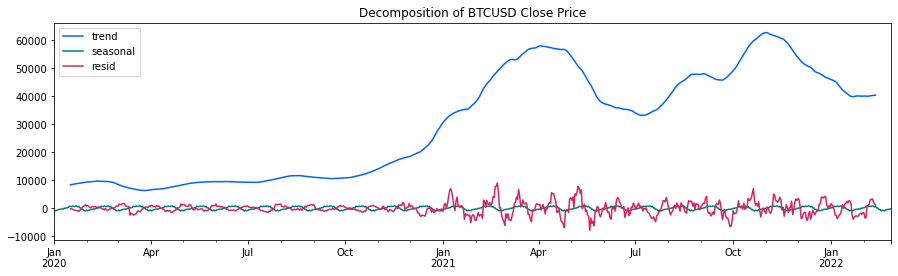

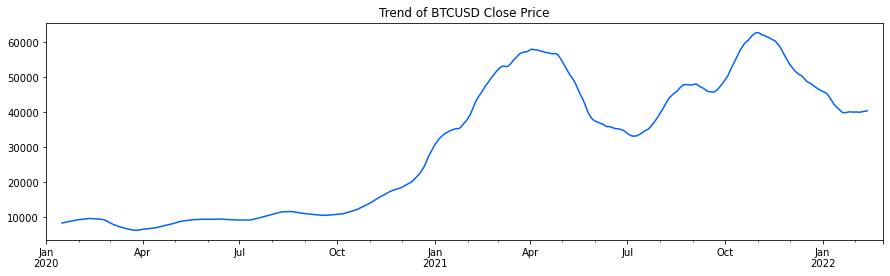

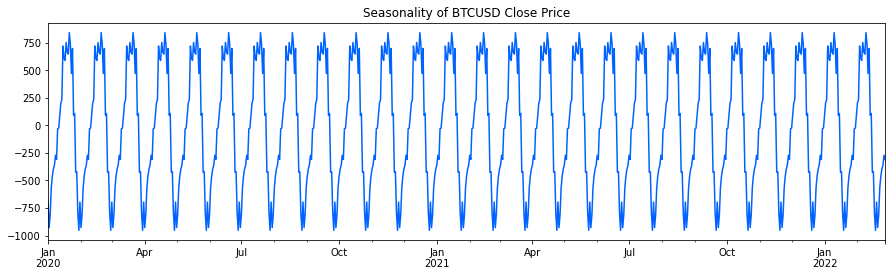

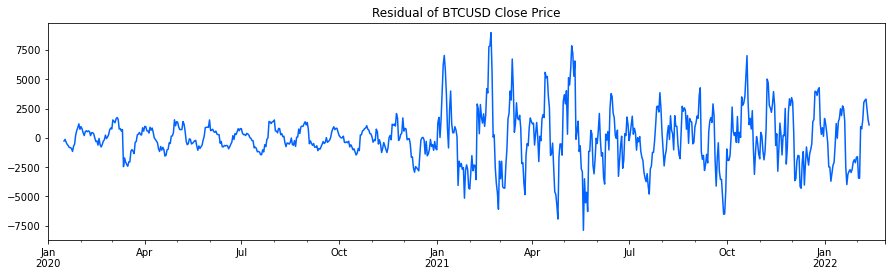

In [14]:
est_trend.plot(figsize = plotsize, title = "Decomposition of BTCUSD Close Price")
est_seasonal.plot()
est_residual.plot()
plt.legend()
plt.show()
est_trend.plot(figsize = plotsize, title =  "Trend of BTCUSD Close Price")
plt.show()
est_seasonal.plot(figsize = plotsize,  title =  "Seasonality of BTCUSD Close Price")
plt.show()
est_residual.plot(figsize = plotsize, title =  "Residual of BTCUSD Close Price")
plt.show()

Then, verify if the residual component of BTCUSD is stationary series. Here p-value is less than 0.05. Therefore, it is stationary. 

In [15]:
est_residual = est_residual.dropna()
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(est_residual[3:-3])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -7.936704877895562
p-value:  3.3983495385926067e-12


### 2.2 Differencing and Log Transformations

In this section, we perform difference and log transformation to obtain stationary series of BTCUSD close price.

***

__Differencing Transformation__

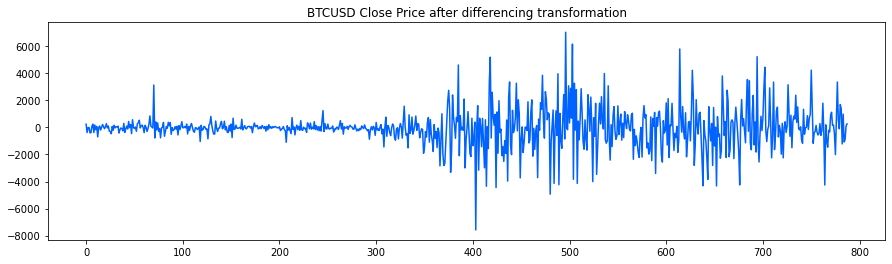

In [16]:
diff_close = data["close"][:-1].reset_index() - data["close"][1:].reset_index()
diff_close["close"].plot(figsize = plotsize, title = "BTCUSD Close Price after differencing transformation")
plt.show()

In [17]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(diff_close["close"])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -29.094760417880497
p-value:  0.0


***
__Log Transformation__

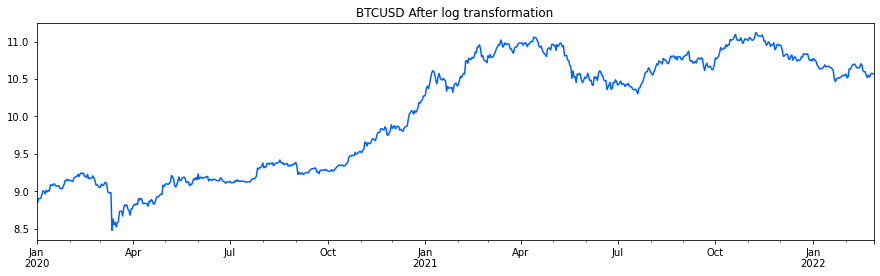

In [18]:
log_close = np.log(data["close"])
log_close.plot(figsize = plotsize, title = "BTCUSD After log transformation")
plt.show()

In [19]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(log_close)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -1.3198374243355602
p-value:  0.6200485119669452


Interestingly, the differencing transformation produces considerably excellent stationary series of close price. Therefore, we can use for the later stage. 

## 3. Smoothing

Here, smoothing does not require data to be stationary. Therefore, we can directly use volume and original close price of BTCUSD.

### 3.1 Moving Average Smoothing

In moving average smmothing, the function below was obtained from the lecture DEMO_Smoothing.

In [20]:
def moving_average(observations, window=3, forecast=False):
    '''returns the smoothed version of an array of observations.'''
    cumulative_sum = np.cumsum(observations, dtype=float)
    cumulative_sum[window:] = cumulative_sum[window:] - cumulative_sum[:-window]
    if forecast:
        return np.insert(cumulative_sum[window - 1:] / window, 0, np.zeros(3))
    else:
        return cumulative_sum[window - 1:] / window

In [21]:
MAS_volume_10 = moving_average(data["volume"].to_numpy(), window=10, forecast=False)
MAS_close_10 = moving_average(data["close"].to_numpy(), window=10, forecast=False)

MAS_volume_100 = moving_average(data["volume"].to_numpy(), window=100, forecast=False)
MAS_close_100 = moving_average(data["close"].to_numpy(), window=100, forecast=False)

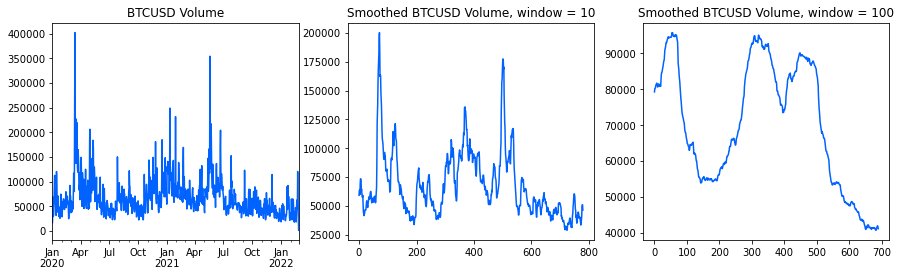

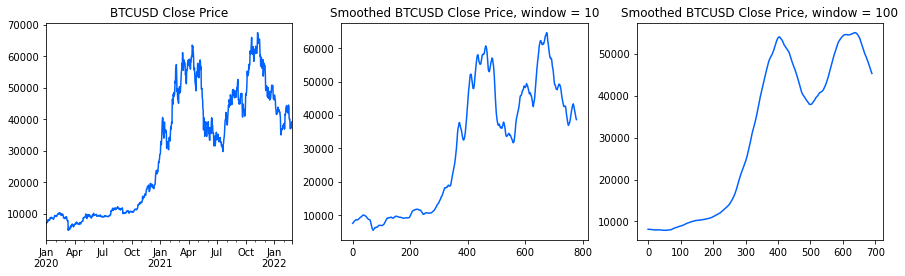

In [22]:
MAS_volume_10 = pd.DataFrame(MAS_volume_10)
MAS_close_10 = pd.DataFrame(MAS_close_10)
MAS_volume_100 = pd.DataFrame(MAS_volume_100)
MAS_close_100 = pd.DataFrame(MAS_close_100)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = plotsize)
data["volume"].plot(ax = ax1, title = "BTCUSD Volume")
MAS_volume_10[0].plot(ax = ax2, title = "Smoothed BTCUSD Volume, window = 10")
MAS_volume_100[0].plot(ax = ax3, title = "Smoothed BTCUSD Volume, window = 100")
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = plotsize)
data["close"].plot(ax = ax1, title = "BTCUSD Close Price")
MAS_close_10[0].plot(ax = ax2, title = "Smoothed BTCUSD Close Price, window = 10")
MAS_close_100[0].plot(ax = ax3, title = "Smoothed BTCUSD Close Price, window = 100")
plt.show()

### 3.2 Exponential Smoothing

mse function below is obtained from the lecture. Then, single exponential and exponential smoothings are applied to smoothen BTCUSD volume and close price. The single exponential and exponential smoothings are compared in graph.

In [23]:
def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

/Users/boomchawit/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/boomchawit/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Predictions:  [54398.4722719 54398.4722719 54398.4722719 54398.4722719 54398.4722719
 54398.4722719 54398.4722719 54398.4722719 54398.4722719 54398.4722719
 54398.4722719 54398.4722719 54398.4722719 54398.4722719 54398.4722719
 54398.4722719 54398.4722719 54398.4722719 54398.4722719 54398.4722719
 54398.4722719 54398.4722719 54398.4722719 54398.4722719 54398.4722719
 54398.4722719 54398.4722719 54398.4722719 54398.4722719 54398.4722719]
MSE:  19124004593.234936


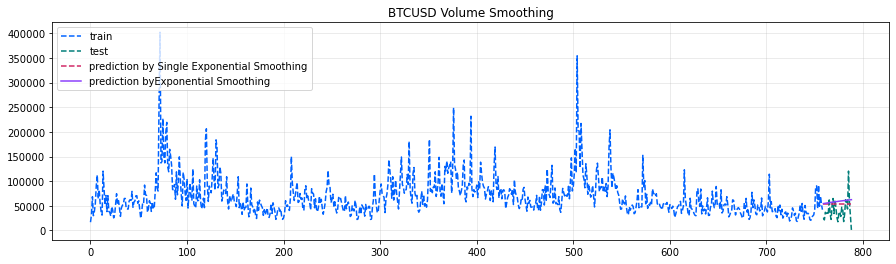

In [24]:
# Train-Test for smoothing
smooth_range = 30
time = np.arange(len(data["close"]))
train_volume = data["volume"][:-smooth_range].to_numpy()
test_volume = data["volume"][-smooth_range:].to_numpy()

# Simple Exponential Smoothing
single = SimpleExpSmoothing(train_volume).fit(optimized=True)
single_preds = single.forecast(len(test_volume))
single_mse = mse(test_volume, single_preds)
print("Predictions: ", single_preds)
print("MSE: ", single_mse)

# Exponential Smoothing
Exponential_Smoothing = ExponentialSmoothing(train_volume,damped=True,
                              trend="additive",
                              seasonal=None,
                              seasonal_periods=None).fit(optimized=True)

prediction_volume = Exponential_Smoothing.forecast(len(test_volume))


# Plots
plt.figure(figsize = plotsize)
plt.plot(time[:-smooth_range], train_volume, '--', label="train")
plt.plot(time[-smooth_range:], test_volume, linestyle="--", label="test")
plt.plot(time[-smooth_range:], single_preds, '--', label="prediction by Single Exponential Smoothing")
plt.plot(time[-smooth_range:], prediction_volume, label = "prediction byExponential Smoothing")
plt.legend(loc='upper left')
plt.title("BTCUSD Volume Smoothing")
plt.grid(alpha=0.3);

Predictions:  [37694.02061188 37694.02061188 37694.02061188 37694.02061188
 37694.02061188 37694.02061188 37694.02061188 37694.02061188
 37694.02061188 37694.02061188 37694.02061188 37694.02061188
 37694.02061188 37694.02061188 37694.02061188 37694.02061188
 37694.02061188 37694.02061188 37694.02061188 37694.02061188
 37694.02061188 37694.02061188 37694.02061188 37694.02061188
 37694.02061188 37694.02061188 37694.02061188 37694.02061188
 37694.02061188 37694.02061188]
MSE:  405933873.2834032


/Users/boomchawit/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


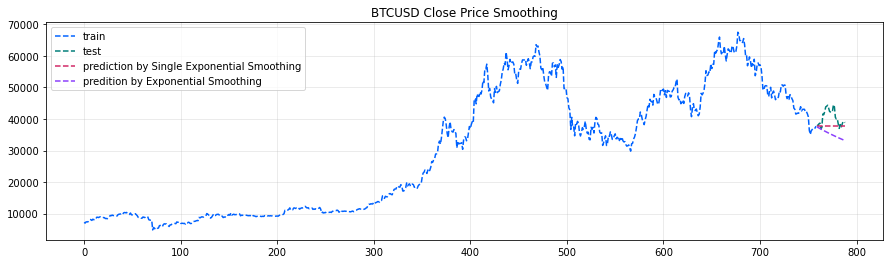

In [25]:
smooth_range = 30

time = np.arange(len(data["close"]))
train_close = data["close"][:-smooth_range].to_numpy()
test_close = data["close"][-smooth_range:].to_numpy()

single = SimpleExpSmoothing(train_close).fit(optimized=True)
single_preds = single.forecast(len(test_close))
single_mse = mse(test_close, single_preds)
print("Predictions: ", single_preds)
print("MSE: ", single_mse)

Exponential_Smoothing = ExponentialSmoothing(train_close,damped=True,
                              trend="additive",
                              seasonal=None,
                              seasonal_periods=None).fit(optimized=True)

prediction_close = Exponential_Smoothing.forecast(len(test_close))

plt.figure(figsize = plotsize)
plt.plot(time[:-smooth_range], train_close, '--', label="train")
plt.plot(time[-smooth_range:], test_close, linestyle="--", label="test")
plt.plot(time[-smooth_range:], single_preds, '--', label="prediction by Single Exponential Smoothing")
plt.plot(time[-smooth_range:], prediction_close, '--', label = "predition by Exponential Smoothing")
plt.legend(loc='upper left')
plt.title("BTCUSD Close Price Smoothing")
plt.grid(alpha=0.3);

Overall, the exponential smoothings are excessively smooth. In my perspective, moving average smoothing performs better in the BTCUSD case. However, the later section will not use smoothened data. Therefore, this is only to practice for future usage. 

## 4. Models (ARMA)

ARMA, ARIMA, SARIMA need the series to be stationary. Therefore, the volume and differenced close price can be inputted in the model. Here below are the chosen series

In [26]:
volume = data["volume"]
close = diff_close["close"]

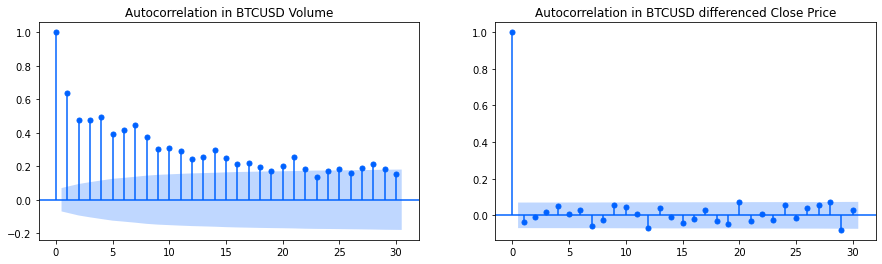

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = plotsize)
acf_volume = plot_acf(volume, ax = ax1, lags = 30, title = 'Autocorrelation in BTCUSD Volume')
acf_close = plot_acf(close, ax = ax2, lags = 30, title = 'Autocorrelation in BTCUSD differenced Close Price')

__[Box-Jenkins Method](https://en.wikipedia.org/wiki/Box–Jenkins_method)__


ACF Shape|Indicated Model
---|---
Exponential, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model.
Alternating positive and negative, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to help identify the order.
One or more spikes, rest are essentially zero|Moving average model, order identified by where plot becomes zero.
Decay, starting after a few lags|Mixed autoregressive and moving average (ARMA) model.
All zero or close to zero|Data are essentially random.
High values at fixed intervals|Include seasonal autoregressive term.
No decay to zero|Series is not stationary.

According to __Box-Jenkins Method__ shown above, the ACF plots of volume and close price are plotted again below. The volume series seemed to be exponential, decaying to zero, while the differenced close price seemed to have one spike (rest are essentially zero). 


Therefore, __volume__ will be modeled by __Autoregressive model (AR)__ while __differenced close price__ will be modeled by __Moving Average model (MA)__.

### 4.1 Autoregressive on Volume

Since the volume series is the exponential, decaying to zero, the autoregressive model is used. The partial autocorrelation is applied to identify the order of the autoregressive model. Plotting PACF obtains the order to be 2. Therefore, we can now directly apply autoregressive model.

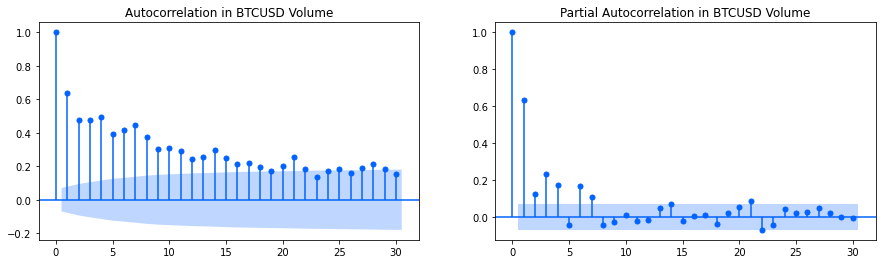

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = plotsize)
acf_volume = plot_acf(volume, ax = ax1, lags = 30, title = 'Autocorrelation in BTCUSD Volume')
pacf = plot_pacf(volume, ax = ax2, lags = 30, title = 'Partial Autocorrelation in BTCUSD Volume')

In [29]:
ARmodel_volume = sm.tsa.ARMA(volume, (2, 0)).fit(trend='nc', disp=0)
ARmodel_volume.params

/Users/boomchawit/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ar.L1.volume    0.683249
ar.L2.volume    0.248575
dtype: float64

This means the volume equals to

<center> $Volume_n = 0.683 * Volume_{n-1} + 0.249 * Volume_{n-2} + Error$

### 4.2 Moving Average on Differenced Close Price

Since the differenced close price series has one spike, the moving average model (MA) is used. The order is decided by when the autocorrelation becomes zero. Here, the order is 1. Therefore, we can obtian MA model.

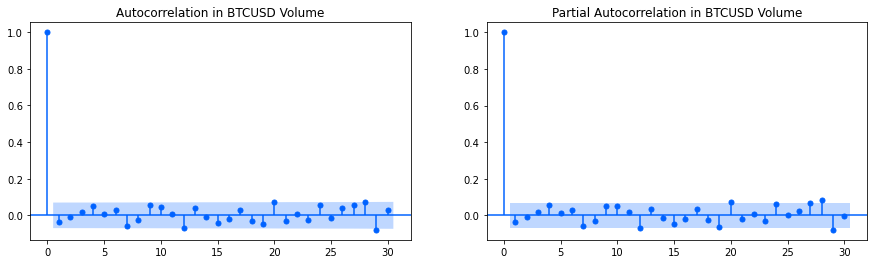

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = plotsize)
acf_volume = plot_acf(close, ax = ax1, lags = 30, title = 'Autocorrelation in BTCUSD Volume')
pacf = plot_pacf(close, ax = ax2, lags = 30, title = 'Partial Autocorrelation in BTCUSD Volume')

In [31]:
model = sm.tsa.ARMA(close, (0, 1)).fit(trend='nc', disp=0)
model.params

ma.L1.close   -0.037253
dtype: float64

## 5. Prediction by RNN and LSTM

Deep Learning models (both recurrent neural network and LSTM) do not require the stationary series. Therefore, volume and price can be directly inputted in the model. Therefore, in this section, we will apply Long Short Term Memory (LSTM) to predict BTCUSD volume and close price in the future. It is dicussable that recurrent neural network or LSTM should be used. Here, since the data are more than 2 years. LSTM, in my opinion, is better. Let's try !

***

### BTCUSD Volume Prediction

In [32]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

def get_keras_format_series(series):
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

In [33]:
# Scale Volume
volume = data.filter(['volume'])

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_volume = scaler.fit_transform(volume)

# Split Train-Test set
training_volume_len = math.ceil(len(volume) *.8)
train_volume = scaled_volume[0:training_volume_len  , : ]

x_train_volume=[]
y_train_volume = []
for i in range(60,len(train_volume)):
    x_train_volume.append(train_volume[i-60:i,0])
    y_train_volume.append(train_volume[i,0])
    
x_train_volume, y_train_volume = np.array(x_train_volume), np.array(y_train_volume)
x_train_volume = np.reshape(x_train_volume, (x_train_volume.shape[0],x_train_volume.shape[1],1))

### BTCUSD Volume: Simple RNN Model

In [34]:
model = Sequential() 

model.add(SimpleRNN(100, input_shape=(x_train_volume.shape[1],1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

2022-02-27 19:23:21.594780: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(x_train_volume, y_train_volume, batch_size=10, epochs=10)

Epoch 1/10
58/58 [==============================] - 1s 8ms/step - loss: 0.0113
Epoch 2/10
58/58 [==============================] - 0s 8ms/step - loss: 0.0068
Epoch 3/10
58/58 [==============================] - 0s 8ms/step - loss: 0.0066
Epoch 4/10
58/58 [==============================] - 0s 8ms/step - loss: 0.0060
Epoch 5/10
58/58 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 6/10
58/58 [==============================] - 0s 8ms/step - loss: 0.0059
Epoch 7/10
58/58 [==============================] - 0s 7ms/step - loss: 0.0059
Epoch 8/10
58/58 [==============================] - 0s 8ms/step - loss: 0.0059
Epoch 9/10
58/58 [==============================] - 0s 8ms/step - loss: 0.0058
Epoch 10/10
58/58 [==============================] - 0s 8ms/step - loss: 0.0062


In [36]:
test_volume = scaled_volume[training_volume_len - 60: , : ]
x_test_volume = []
y_test_volume =  scaled_volume[training_volume_len: , : ]
for i in range(60,len(test_volume)):
    x_test_volume.append(test_volume[i-60:i,0])
    
x_test_volume = np.array(x_test_volume)
x_test_volume = np.reshape(x_test_volume, (x_test_volume.shape[0],x_test_volume.shape[1],1))
x_test_volume.shape

(157, 60, 1)

In [37]:
predictions_volume = model.predict(x_test_volume) 
predictions_volume = scaler.inverse_transform(predictions_volume)

In [38]:
rmse_volume_rnn = np.sqrt(np.mean(((predictions_volume- y_test_volume)**2)))
print("RMSE of simple RNN (Volume)", rmse_volume_rnn)

RMSE of simple RNN (Volume) 45464.90817775854


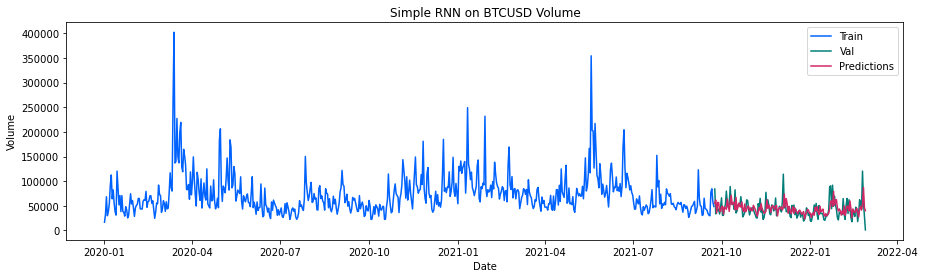

In [39]:
train_volume = volume[:training_volume_len]
valid_volume = volume[training_volume_len:]
valid_volume['Predictions_RNN'] = predictions_volume
#Visualize the data
plt.figure(figsize=plotsize)
plt.title('Simple RNN on BTCUSD Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.plot(train_volume)
plt.plot(valid_volume)
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()

### BTCUSD Volume: LSTM Model

In [40]:
LSTM_model  = Sequential()
LSTM_model .add(LSTM(units=50, return_sequences=True,input_shape=(x_train_volume.shape[1],1)))
LSTM_model .add(LSTM(units=50, return_sequences=False))
LSTM_model .add(Dense(units=25))
LSTM_model .add(Dense(units=1))

LSTM_model.compile(loss='mean_squared_error', optimizer='adam')
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [41]:
LSTM_model.fit(x_train_volume, y_train_volume, batch_size=10, epochs=10)

Epoch 1/10
58/58 [==============================] - 4s 26ms/step - loss: 0.0111
Epoch 2/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0080
Epoch 3/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0076
Epoch 4/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0075
Epoch 5/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0073
Epoch 6/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0072
Epoch 7/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0073
Epoch 8/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0071
Epoch 9/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0071
Epoch 10/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0069


In [42]:
predictions_volume = LSTM_model.predict(x_test_volume) 
predictions_volume = scaler.inverse_transform(predictions_volume)

rmse_volume_LSTM = np.sqrt(np.mean(((predictions_volume - y_test_volume)**2)))
print("RMSE of LSMT (Volume)", rmse_volume_LSTM)

RMSE of LSMT (Volume) 55014.36187272579


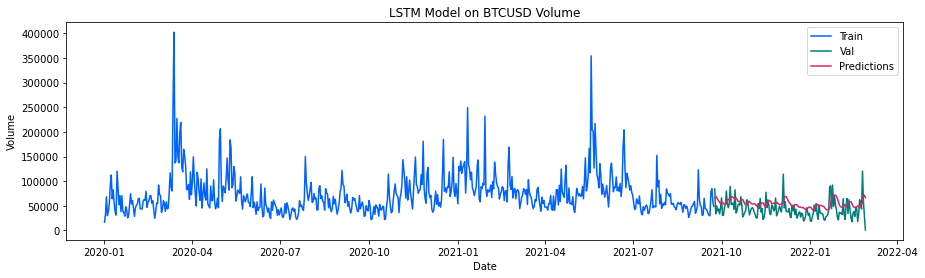

In [43]:
train_volume = volume[:training_volume_len]
valid_volume = volume[training_volume_len:]
valid_volume['Predictions_LSTM'] = predictions_volume
#Visualize the data
plt.figure(figsize=plotsize)
plt.title('LSTM Model on BTCUSD Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.plot(train_volume)
plt.plot(valid_volume)
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()

As seen from RMSE, __for BTCUSD Volume the simple RNN performs better than LSTM.__

Then, we move to price prediction by simple RNN and LSTM as follows.

***

### BTCUSD Close Price Prediction

In [44]:
# Scale Price
close = data.filter(['close'])

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close)

# Split Train-Test set
training_close_len = math.ceil(len(close) *.8)
train_close = scaled_close[0:training_close_len, : ]

x_train_close=[]
y_train_close = []
for i in range(60,len(train_close)):
    x_train_close.append(train_close[i-60:i,0])
    y_train_close.append(train_close[i,0])
    
x_train_close, y_train_close = np.array(x_train_close), np.array(y_train_close)
x_train_close = np.reshape(x_train_close, (x_train_close.shape[0],x_train_close.shape[1],1))

In [45]:
test_close = scaled_close[training_close_len - 60: , : ]
x_test_close = []
y_test_close =  scaled_volume[training_close_len: , : ]
for i in range(60,len(test_close)):
    x_test_close.append(test_close[i-60:i,0])
    
x_test_close = np.array(x_test_close)
x_test_close = np.reshape(x_test_close, (x_test_close.shape[0],x_test_close.shape[1],1))
x_test_close.shape

(157, 60, 1)

### BTCUSD Close Price: Simple RNN Model

In [46]:
model = Sequential() 

model.add(SimpleRNN(100, input_shape=(x_train_close.shape[1],1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.fit(x_train_close, y_train_close, batch_size=10, epochs=10)

Epoch 1/10
58/58 [==============================] - 1s 6ms/step - loss: 0.0090
Epoch 2/10
58/58 [==============================] - 0s 6ms/step - loss: 8.7150e-04
Epoch 3/10
58/58 [==============================] - 0s 6ms/step - loss: 8.6303e-04
Epoch 4/10
58/58 [==============================] - 0s 6ms/step - loss: 8.1684e-04
Epoch 5/10
58/58 [==============================] - 0s 6ms/step - loss: 9.2571e-04
Epoch 6/10
58/58 [==============================] - 0s 6ms/step - loss: 8.0541e-04
Epoch 7/10
58/58 [==============================] - 0s 6ms/step - loss: 7.7553e-04
Epoch 8/10
58/58 [==============================] - 0s 7ms/step - loss: 7.1901e-04
Epoch 9/10
58/58 [==============================] - 0s 7ms/step - loss: 7.0551e-04
Epoch 10/10
58/58 [==============================] - 0s 6ms/step - loss: 6.2793e-04


In [48]:
predictions_close = model.predict(x_test_close) 
predictions_close = scaler.inverse_transform(predictions_close)
rmse_close_rnn = np.sqrt(np.mean(((predictions_close - y_test_close)**2)))
print("RMSE of Simple RNN (close price):", rmse_close_rnn)

RMSE of Simple RNN (close price): 48061.609780582956


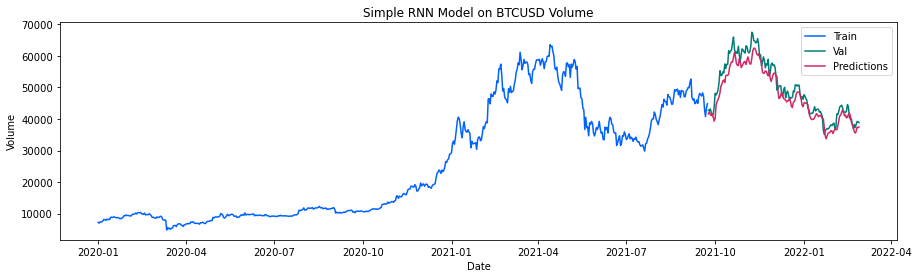

In [49]:
train_close = close[:training_close_len]
valid_close = close[training_close_len:]
valid_close['Predictions_RNN'] = predictions_close

#Visualize the data
plt.figure(figsize=plotsize)
plt.title('Simple RNN Model on BTCUSD Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.plot(train_close)
plt.plot(valid_close)
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()

### BTCUSD Close Price: LSTM

In [50]:
LSTM_model  = Sequential()
LSTM_model .add(LSTM(units=50, return_sequences=True,input_shape=(x_train_close.shape[1],1)))
LSTM_model .add(LSTM(units=50, return_sequences=False))
LSTM_model .add(Dense(units=25))
LSTM_model .add(Dense(units=1))

LSTM_model.compile(loss='mean_squared_error', optimizer='adam')
LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [51]:
LSTM_model.fit(x_train_close, y_train_close, batch_size=10, epochs=10)

Epoch 1/10
58/58 [==============================] - 4s 26ms/step - loss: 0.0249
Epoch 2/10
58/58 [==============================] - 2s 30ms/step - loss: 0.0025
Epoch 3/10
58/58 [==============================] - 2s 30ms/step - loss: 0.0026
Epoch 4/10
58/58 [==============================] - 2s 26ms/step - loss: 0.0020
Epoch 5/10
58/58 [==============================] - 2s 30ms/step - loss: 0.0018
Epoch 6/10
58/58 [==============================] - 2s 32ms/step - loss: 0.0018
Epoch 7/10
58/58 [==============================] - 2s 31ms/step - loss: 0.0018
Epoch 8/10
58/58 [==============================] - 2s 28ms/step - loss: 0.0016
Epoch 9/10
58/58 [==============================] - 2s 29ms/step - loss: 0.0016
Epoch 10/10
58/58 [==============================] - 2s 28ms/step - loss: 0.0015


In [52]:
predictions_close = LSTM_model.predict(x_test_close) 
predictions_close = scaler.inverse_transform(predictions_close)

rmse_close_LSTM = np.sqrt(np.mean(((predictions_close - y_test_close)**2)))
print("RMSE of LSMT (close price):", rmse_close_LSTM)

RMSE of LSMT (close price): 51771.647570082256


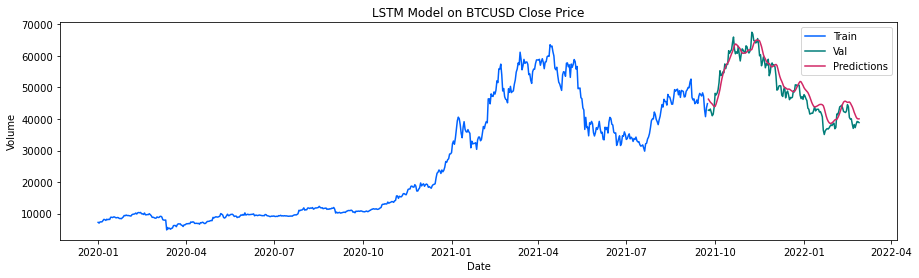

In [53]:
train_close = close[:training_close_len]
valid_close = close[training_close_len:]
valid_close['Predictions_LSTM'] = predictions_close
#Visualize the data
plt.figure(figsize=plotsize)
plt.title('LSTM Model on BTCUSD Close Price')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.plot(train_close)
plt.plot(valid_close)
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()

In [54]:
print("RMSE of RNN (volume):", rmse_volume_rnn)
print("RMSE of LSMT (volume):", rmse_volume_LSTM)
print("RMSE of RNN (close price):", rmse_close_rnn)
print("RMSE of LSMT (close price):", rmse_close_LSTM)

RMSE of RNN (volume): 45464.90817775854
RMSE of LSMT (volume): 55014.36187272579
RMSE of RNN (close price): 48061.609780582956
RMSE of LSMT (close price): 51771.647570082256


Therefore, 

<h3><center> Simple RNN performs better for both VOLUME and CLOSE PRICE. </center></h3>

## 6. Summary

In this notebook, we have practice almost all tools in lectures, except survival analysis because it might not be suitable for this time series data. Therefore, only 6 aspects are practiced. These include upsampling, autocorrelation, transformation, smoothing, and deep learning. Future plan can be 

> <li> extension to larger dataset </li>
> <li> extension to other cryptocurrencies or stocks</li>
> <li> Real-time prediction </li>

***
### Chawit Kaewnuratchadasorn
IBM Machine Learning Professional Certificate<br>
__Specialized Models: Time Series and Survival Analysis__